In [2]:
import bhnerf
import bhnerf.constants as consts
import numpy as np
from astropy import units
import ehtim as eh
from flax.training import checkpoints
import matplotlib.pyplot as plt

import importlib


/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/ehtim/__init__.py:56: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Welcome to eht-imaging! v 1.2.4 



In [3]:
"""
Generate synthetic observations of a hot-spot
"""
fov_M = 16.0
z_width = 4
rmax = fov_M/2
spin = 0.2
inclination = np.deg2rad(60.0)      
nt = 64
array = 'ngEHT'             
flux_scale = 0.1                    # scale image-plane fluxes to `reasonable` values in Jy
tstart = 2.0 * units.hour           # observation start time
tstop = tstart + 40.0 * units.min   # observation stop time

# Compute geodesics (see Tutorial1)
geos = bhnerf.kgeo.image_plane_geos(
    spin, inclination, 
    num_alpha=64, num_beta=64, 
    alpha_range=[-fov_M/2, fov_M/2],
    beta_range=[-fov_M/2, fov_M/2]
)
Omega = np.sign(spin + np.finfo(float).eps) * np.sqrt(geos.M) / (geos.r**(3/2) + geos.spin * np.sqrt(geos.M))
t_injection = -float(geos.r_o)
rmin = float(geos.r.min())

# Generate hotspot measurements (see Tutorial2) 
emission_0 = flux_scale * bhnerf.emission.generate_hotspot_xr(
    resolution=(64, 64, 64), 
    rot_axis=[0.0, 0.0, 1.0], 
    rot_angle=0.0,
    orbit_radius=5.5,
    std=0.7,
    r_isco=bhnerf.constants.isco_pro(spin),
    fov=(fov_M, 'GM/c^2')
)
obs_params = {
    'mjd': 57851,                       # night of april 6-7, 2017
    'timetype': 'GMST',
    'nt': nt,                           # number of time samples 
    'tstart': tstart.to('hr').value,    # start of observations
    'tstop': tstop.to('hr').value,      # end of observation 
    'tint': 30.0,                       # integration time,
    'array': eh.array.load_txt('../eht_arrays/{}.txt'.format(array))
}
obs_empty = bhnerf.observation.empty_eht_obs(**obs_params)
fov_rad = (fov_M * consts.GM_c2(consts.sgra_mass) / consts.sgra_distance.to('m')) * units.rad
psize = fov_rad.value / geos.alpha.size 
obs_args = {'psize': psize, 'ra': obs_empty.ra, 'dec': obs_empty.dec, 'rf': obs_empty.rf, 'mjd': obs_empty.mjd}
t_frames = np.linspace(tstart, tstop, nt)
image_plane = bhnerf.emission.image_plane_dynamics(emission_0, geos, Omega, t_frames, t_injection)
movie = eh.movie.Movie(image_plane, times=t_frames.value, **obs_args)
obs = bhnerf.observation.observe_same(movie, obs_empty, ttype='direct', seed=None)

2025-08-22 12:41:16.427510: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Producing clean visibilities from movie with direct FT . . . 
Applying Jones Matrices to data . . . 
Adding thermal noise to data . . . 
Applying a priori calibration with estimated Jones matrices . . . 


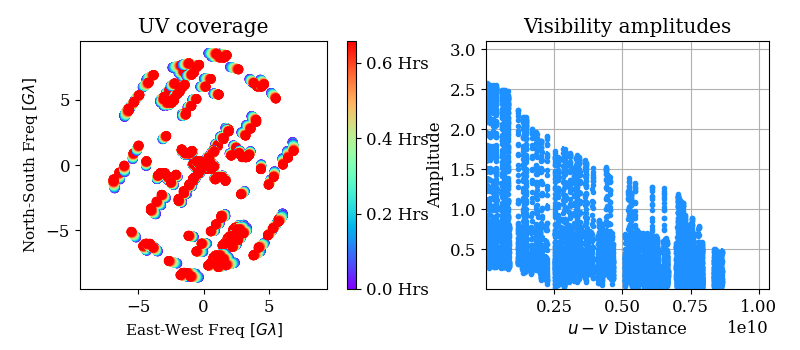

In [3]:
%matplotlib widget
fig, ax = plt.subplots(1, 2, figsize=(8,3.5))
ax[0].set_title('UV coverage')
ax[1].set_title('Visibility amplitudes')
bhnerf.observation.plot_uv_coverage(obs, ax=ax[0], cmap_ticks=[0,0.2, 0.4, 0.6], fontsize=11)
obs.plotall('uvdist', 'amp', axis=ax[1])
plt.tight_layout()

In [4]:
"""reload a pretrained network"""
chisqdata = eh.imaging.imager_utils.chisqdata_vis

checkpoint_dir = '/srv/tmp/kyle/bhnerf/checkpoints/tutorial4/recovery.vis.2025-08-05.09:51:12/'
predictor = bhnerf.network.NeRF_Predictor.from_yml(checkpoint_dir)
state = checkpoints.restore_checkpoint(checkpoint_dir, None)

params = state['params']
raytracing_args = bhnerf.network.raytracing_args(geos, Omega, t_injection, t_frames[0])

/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.0, max=1.0, step…

(64, 64, 64)


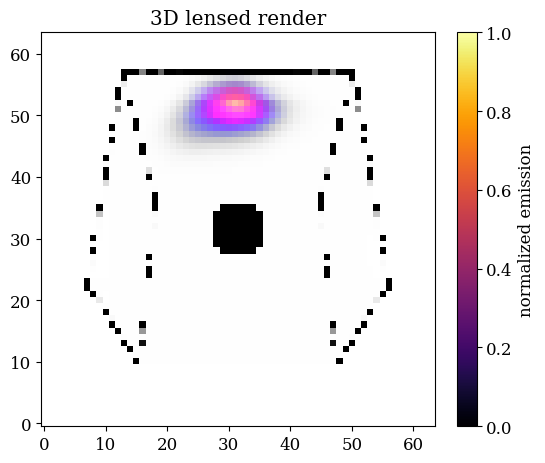

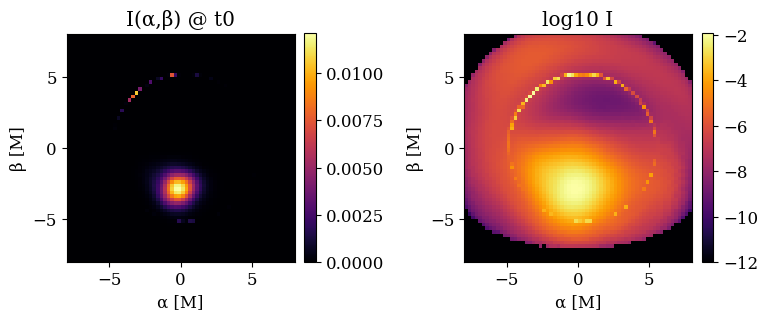

In [7]:
"""Visualize the recovered emission from bhnerf"""
import jax.numpy as jnp

### render 3D static emission
emission_estimate = bhnerf.network.sample_3d_grid(predictor.apply, params, fov=fov_M)
bhnerf.visualization.ipyvolume_3d(emission_estimate, fov=fov_M, level=[0, 0.2, 0.7])
print(emission_estimate.shape)

### render 3D lensed emission
viz = bhnerf.visualization.VolumeVisualizer(width=64, height=64, samples=64)
viz.set_view(cam_r=37.0, domain_r=fov_M/2, azimuth=0.0, zenith=inclination, up=np.array([0.,0.,1.]))
img_approx = viz.render(emission_estimate/(emission_estimate.max()+1e-12), facewidth=fov_M, jit=True, bh_radius=2.0, linewidth=0.1, cmap='inferno')
img_approx = np.nan_to_num(img_approx, nan=0.0, posinf=1.0, neginf=0.0)
img_approx = np.clip(img_approx, 0.0, 1.0)

fig, ax = plt.subplots()
ax.imshow(img_approx, origin='lower', cmap='inferno')
ax.set_title("3D lensed render")
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(norm=norm, cmap='inferno')
fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label='normalized emission')
plt.tight_layout()
plt.show()

### render 2D image plane emission
t0 = t_frames[0]
img = bhnerf.network.image_plane_prediction(
    params, predictor.apply,
    t_frames=t0,
    **raytracing_args,
    t_units=None
)

alpha = np.asarray(geos.alpha)
beta = np.asarray(geos.beta)
extent = [alpha.min(), alpha.max(), beta.min(), beta.max()]

fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(img, origin='lower', extent=extent, cmap='inferno', aspect='equal')
axes[0].set_title('I(α,β) @ t0'); axes[0].set_xlabel('α [M]'); axes[0].set_ylabel('β [M]')
plt.colorbar(axes[0].images[0], ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(np.log10(np.asarray(img)+1e-12), origin='lower', extent=extent, cmap='inferno', aspect='equal')
axes[1].set_title('log10 I'); axes[1].set_xlabel('α [M]'); axes[1].set_ylabel('β [M]')
plt.colorbar(axes[1].images[0], ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



(64, 64, 64)
[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
[Recovered emission interpolation check] shape=(64, 64, 64)
  max |trilinear - original|   : 1.816079020500183e-08
  max |map_coords - original|  : 1.816079020500183e-08
  max |trilinear - map_coords| : 9.313225746154785e-10


/srv/tmp/kyle/bhnerf/bhnerf/uncertainty.py:214: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.colorbar(im0, ax=[axs[0], axs[1], axs[2]], shrink=0.75)


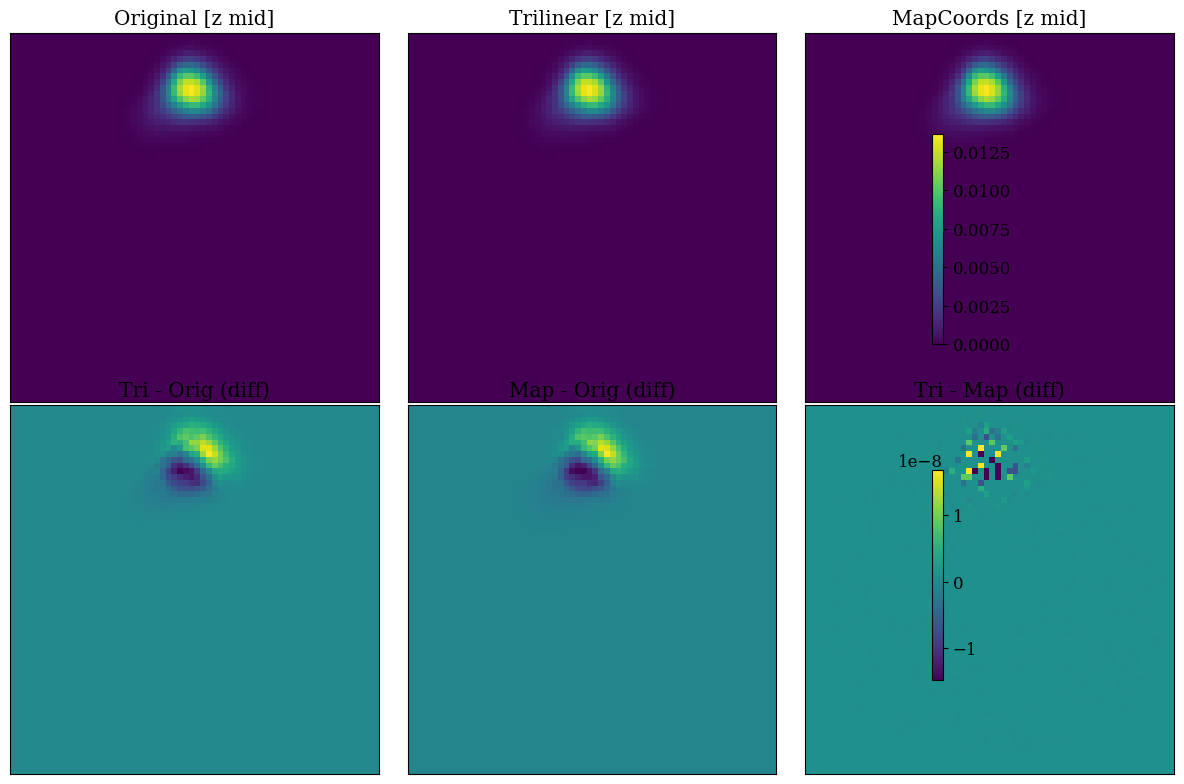

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.0, max=1.0, step…

/srv/tmp/kyle/miniconda3/envs/jax/lib/python3.9/site-packages/ipyvolume/serialize.py:92: RuntimeWarning: divide by zero encountered in divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.0, max=1.0, step…

Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.0, max=1.0, step…

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


In [17]:
importlib.reload(bhnerf.uncertainty)
import bhnerf.uncertainty as unc

print(emission_estimate.shape)
print(emission_estimate[0:5, 0:5, 0:5])

unc.interpolation_check_scalar(emission_estimate, fov_M, title="Recovered emission interpolation check")

In [21]:
"""initialize uncertainty class and params. we'll compute the uncertainty in the first frame and propagate forward in time"""
importlib.reload(bhnerf.uncertainty)
import bhnerf.uncertainty as unc

k = 0 # compute uncertainty at frame 0
times, sigma, A = unc.build_A_per_frame(obs, t_frames, movie.fovx(), movie.xdim)

A = A[k]
sigma = sigma[k]

print("\n----------full movie params----------")
for key in raytracing_args.keys():
    if key == "J":
        print("J:", {raytracing_args[key]})
    elif key == "t_injection":
        print("t_injection:", {raytracing_args[key]})
    else:
        print(f"{key} shape:",raytracing_args[key].shape)


forward_model = unc.make_forward_model(predictor.apply, params, t_frames[0], raytracing_args, A)
br_unc = unc.BayesRaysUncertaintyMapper(predictor.apply, params, forward_model, raytracing_args, t_frames[0], A, fov_M, z_width, grid_res=(16, 16, 16), lam=1e-6/64**3)

Splitting Observation File into 64 times

----------full movie params----------
coords shape: (3, 64, 64, 100)
Omega shape: (64, 64, 100)
J: {1.0}
g shape: (64, 64, 100)
dtau shape: (64, 64, 100)
Sigma shape: (64, 64, 100)
t_start_obs shape: ()
t_geos shape: (64, 64, 100)
t_injection: {-1000.0}

----------single frame params----------
Omega: (64, 64, 100)
g: (64, 64, 100)
dtau:  (64, 64, 100)
Sigma:  (64, 64, 100)
t_geos:  (64, 64, 100)
Coords (forward model): (3, 64, 64, 100)
Coords (bayesrays): (64, 64, 100, 3)
Coords min and max: 999.41284 -999.78613
Coords unit min, max: 0.99504954 0.004950464
Coords unit shape: (64, 64, 100, 3) Coords shape: (64, 64, 100, 3)


In [22]:
"""compute the hessian"""
nvis = sigma.shape[0]
H, R_eff = br_unc.compute_hessian_diag(sigma.reshape(-1), batch_size=1)
V = br_unc.get_covariance(H, nvis=nvis)

print("-"*20)
print("H MATRIX:", H, "SHAPE:", H.shape)
print("V MATRIX:", V, "SHAPE:", V.shape)

iteration:   0%|          | 0/153 [00:00<?, ?it/s]

2025-08-22 13:57:54.795720: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %multiply.243 = f32[64,64,100,8,3]{4,3,2,1,0} multiply(f32[64,64,100,8,3]{4,3,2,1,0} %constant.619, f32[64,64,100,8,3]{4,3,2,1,0} %broadcast.242), metadata={op_name="jit(_fisher_diag_row)/jit(main)/vmap(jvp(DeformationGrid))/mul" source_file="/srv/tmp/kyle/bhnerf/bhnerf/uncertainty.py" source_line=292}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-08-22 13:57:59.103734: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 8.308171918s
Constant folding an instruction is taking > 4

computing covariance matrix with lambda: 3.814697265625e-12
--------------------
H MATRIX: [0. 0. 0. ... 0. 0. 0.] SHAPE: (12288,)
V MATRIX: [1.31072e+11 1.31072e+11 1.31072e+11 ... 1.31072e+11 1.31072e+11
 1.31072e+11] SHAPE: (12288,)


Container(children=[VBox(children=(HBox(children=(Label(value='levels:'), FloatSlider(value=0.1, max=1.0, step…

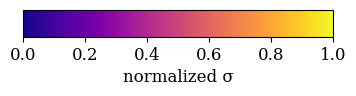

In [23]:
"""render and visualize 3D uncertainty (static)"""

level_norm = (0.0, 0.3, 0.6, 0.9)
opacity = (0.00, 0.25, 0.3, 0.5)
opacity = (0.2, 0.10, 0.05, 0.00)
br_unc.render_uncertainty_3d(H, V, fov_M, cmap='plasma', level_norm=level_norm, opacity=opacity, resolution=128, squared_weights=False)


(1, 64, 64, 64)
[debug] σ0 slice stats (masked): min=4.806, max=5.797, clip=(4.902,5.797), coverage=0.8467


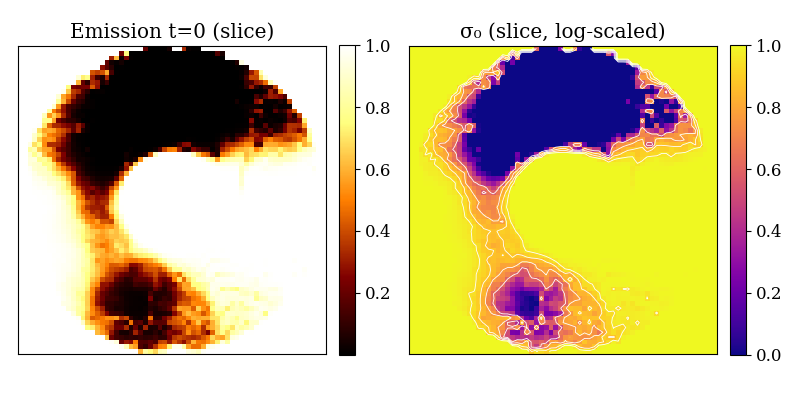

In [10]:
"""inspect a 2D slice of the recovered uncertainty"""
import matplotlib.pyplot as plt
importlib.reload(bhnerf.uncertainty)
sigmas = br_unc.upsample(V, resolution=64, squared_weights=False)
sigmas = sigmas[None, ...]
print(sigmas.shape)

show_initial_covariance_slice(V, 64, sigmas, axis=2, rel_thresh=0.01)

In [11]:
"""propagate uncertainty forward in time"""
br_unc.t_frames = t_frames
R = 128

var0 = br_unc.upsample(V, resolution=R)
sigma_ts = br_unc.propagate_positional_variance(sigma0_var=var0, t_frames=t_frames, fov_M=fov_M, 
R=128, spin=spin, M=1.0, rot_axis=(0.,0.,1.), chunk_pts=32768) # propagate forward in time according to the dynamics in emission.py

rendering frame:   0%|          | 0/64 [00:00<?, ?it/s]

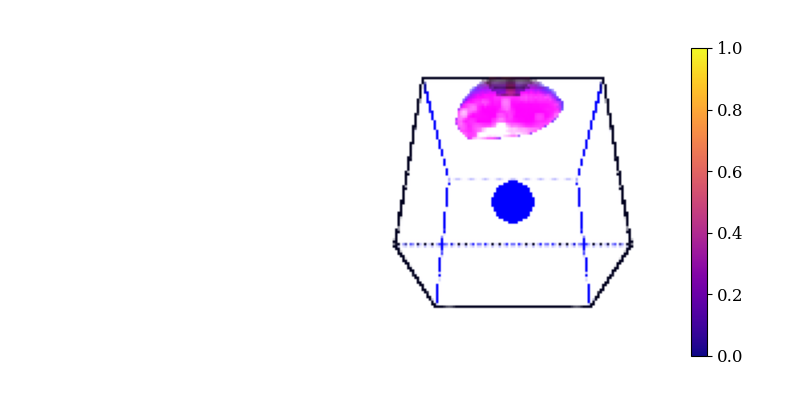

In [13]:
"""render time dependent uncertainty"""
# for dynamic masking
network_movie = br_unc.build_emission_movie(t_frames=t_frames, fov_M=fov_M, R=R, spin=spin) 
# 0 out where there is no emission
masks = bhnerf.uncertainty.build_dynamic_mask(network_movie, relative_threshold=0.01) 
# mask, clip, log scale
sigma_ts_render = bhnerf.uncertainty.prepare_unc_for_render(sigma_ts, mask=masks) 

visualizer = bhnerf.visualization.VolumeVisualizer(R, R, R)
%matplotlib widget
anim = bhnerf.visualization.render_3d_movie(sigma_ts_render, t_frames, visualizer, cam_r=37.0, rmax=predictor.rmax, bh_radius=2.0, linewidth=0.1, cmap='plasma', azimuth=0, zenith=inclination, normalize=False)

rendering frame:   0%|          | 0/64 [00:00<?, ?it/s]

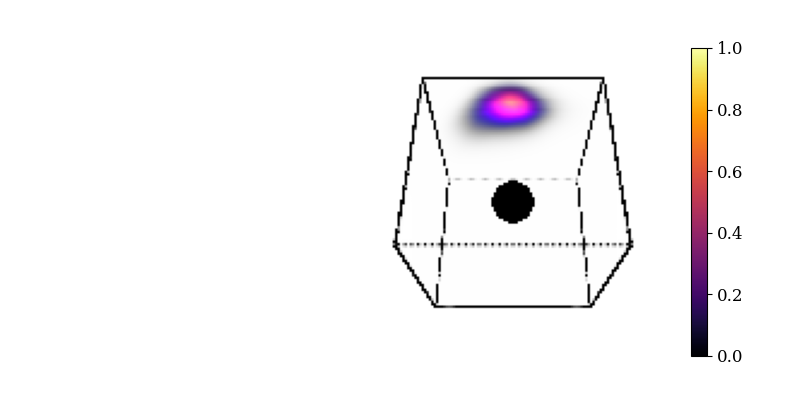

In [45]:
emission_anim = bhnerf.visualization.render_3d_movie(network_movie, t_frames, visualizer, cam_r=37.0, rmax=predictor.rmax, bh_radius=2.0, linewidth=0.1, cmap='inferno', azimuth=0, zenith=inclination, normalize=True, resolution=128)


In [ ]:
#emission_anim.save('../results/bayesrays/3Dmovie_grid_res64_emission.mp4', 'ffmpeg', fps=20, bitrate=1e6)
import jax.numpy as jnp
off = jnp.zeros_like(br_unc.coords).at[..., 0].set(0.1)  # +0.1M in x only
dvis = br_unc.forward_model(br_unc.coords + off) - br_unc.forward_model(br_unc.coords)
print("mean |Δvis|:", float(jnp.mean(jnp.abs(dvis))))


NameError: name 'jnp' is not defined

In [11]:
"""render the time propagated 2D uncertainty and movie on the z-axis"""
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def center_slice(vol4, fixed='z'):  # (nt,R,R,R) -> (nt,R,R)
    _, R, _, _ = vol4.shape
    mid = R // 2
    if fixed == 'x':
        slab = vol4[:, mid, :, :]
        return np.swapaxes(slab, 2, 1)
    elif fixed == 'y':
        slab = vol4[:, :, mid, :]
        return slab.transpose(0,2,1)
    else:
        slab = vol4[:, :, :, mid]
        return slab

movie_2d = center_slice(network_movie, fixed='z') # (nt,R,R)
unc_2d = center_slice(sigma_ts, fixed='z') # (nt,R,R)

# normalize for display
movie_disp  = movie_2d / (movie_2d.max(axis=(1,2), keepdims=True) + 1e-12)
uncertainty_disp = unc_2d / (unc_2d.max(axis=(1,2), keepdims=True) + 1e-12)

movie_da  = xr.DataArray(movie_disp,  dims=('t','y','x'), coords={'t': t_frames})
unc_da = xr.DataArray(uncertainty_disp, dims=('t','y','x'), coords={'t': t_frames})

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
anim2d = bhnerf.visualization.animate_movies_synced(
    [movie_da, unc_da], axes=axes,
    cmaps=['afmhot', 'plasma'],
    titles=['Emission (slice)', 'Uncertainty (slice)'], 
    fps=20,
    output='../results/bayesrays/grid_res64_propagated_no_transpose.mp4'
)
for ax in axes: ax.axis('off')
plt.tight_layout()


NameError: name 'network_movie' is not defined

In [9]:
R = 64
def show_initial_covariance_slice(V_diag, R, network_movie, axis=2, rel_thresh=0.01, percent_clip=(1, 99)):
    var0 = br_unc.upsample(V_diag, resolution=R)
    sigma0 = np.sqrt(var0 + 1e-12)

    em0 = np.asarray(network_movie[0])
    m0 = em0 > (em0.max() * rel_thresh)

    mid = R // 2
    if axis == 0:
        em_sl   = em0[mid, :, :]
        sig_sl  = sigma0[mid, :, :]
        mask_sl = m0[mid, :, :]
    elif axis == 1:
        em_sl   = em0[:, mid, :]
        sig_sl  = sigma0[:, mid, :]
        mask_sl = m0[:, mid, :]
    else:
        em_sl   = em0[:, :, mid]
        sig_sl  = sigma0[:, :, mid]
        mask_sl = m0[:, :, mid]

    u = np.log10(sig_sl * mask_sl + 1e-12)
    vmin, vmax = np.nanpercentile(u[mask_sl], percent_clip) if mask_sl.any() else (u.min(), u.max())
    u_disp = np.clip(u, vmin, vmax)
    u_disp = (u_disp - vmin) / (vmax - vmin + 1e-12)

    em_disp = em_sl / (em_sl.max() + 1e-12)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axes[0].imshow(em_disp, origin='lower', cmap='afmhot')
    axes[0].set_title('Emission t=0 (slice)')
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(u_disp, origin='lower', cmap='plasma')
    cs = axes[1].contour(em_disp, levels=[0.2, 0.4, 0.6, 0.8], colors='w', linewidths=0.6)
    axes[1].set_title('σ₀ (slice, log-scaled)')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    for ax in axes: ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()

    print(f"[debug] σ0 slice stats (masked): min={np.nanmin(u[mask_sl]):.3f}, max={np.nanmax(u[mask_sl]):.3f}, "
          f"clip=({vmin:.3f},{vmax:.3f}), coverage={mask_sl.mean():.4f}")
    
V = br_unc.get_covariance(H, nvis=sigma.shape[0])

show_initial_covariance_slice(V, R, network_movie, axis=2, rel_thresh=0.01)

computing covariance matrix with lambda: 3.814697265625e-12


NameError: name 'network_movie' is not defined